# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.804779,True,7.370380
1,0.493811,True,4.978687
2,-0.113740,True,4.909221
3,-0.032150,True,6.343420
4,1.520886,True,8.037291
...,...,...,...
995,2.083107,True,7.268335
996,0.934966,True,6.459352
997,0.677021,True,6.892703
998,0.502681,True,4.899572


<AxesSubplot:xlabel='v0'>

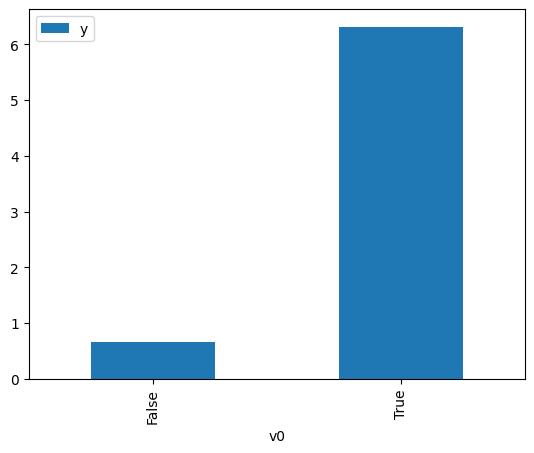

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

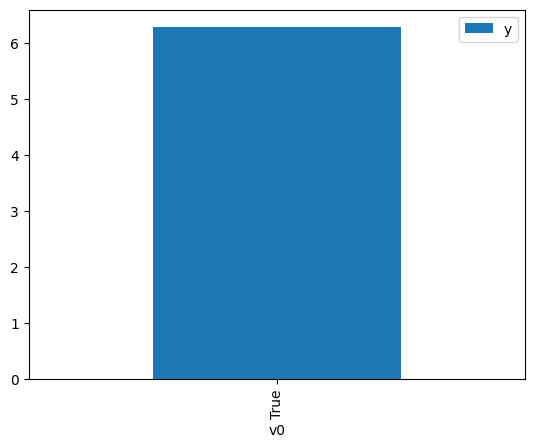

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.189536,False,1.456717,0.042536,23.509720
1,-0.549965,False,-1.566646,0.816607,1.224579
2,-0.215710,False,-1.299680,0.647524,1.544343
3,1.752461,False,1.772318,0.009903,100.981467
4,0.902115,False,1.037482,0.086856,11.513349
...,...,...,...,...,...
995,-0.233157,False,1.154574,0.657998,1.519761
996,0.665133,False,1.003686,0.151235,6.612214
997,0.749963,False,1.864372,0.124593,8.026126
998,1.095807,False,0.326436,0.053876,18.561094


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.031251,True,5.583040,0.936713,1.067563
1,1.753385,True,9.554727,0.990121,1.009977
2,1.396255,True,7.490978,0.974949,1.025694
3,2.873749,True,7.243575,0.999487,1.000513
4,0.319712,True,5.247007,0.692113,1.444851
...,...,...,...,...,...
995,1.083966,True,5.950411,0.944502,1.058758
996,1.416307,True,6.303534,0.976214,1.024365
997,1.590334,True,6.419443,0.984866,1.015367
998,0.969435,True,6.861684,0.926284,1.079583


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.786e+04
Date:                Wed, 07 Sep 2022   Prob (F-statistic):                        0.00
Time:                        07:18:34   Log-Likelihood:                         -1411.7
No. Observations:                1000   AIC:                                      2827.
Df Residuals:                     998   BIC:                                      2837.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2242      0.039     31.003      0.000       1.147       1.302
x2             5.0752      0.061     83.072      0.000       4.955       5.195
==============================================================================
Omnibus:                        2.264   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.322   Jarque-Bera (JB):                2.271
Skew:                          -0.116   Prob(JB):                        0.321
Kurtosis:                       2.973   Cond. No.                         3.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""